In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')
data_df.head()

,input_ct,selected_ct,hamming_dist,training_set,y,dy,x
0,1759616.0,3041819.0,0,True,0.000000,0.001366,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,14663.0,38476.0,1,True,0.602044,0.014001,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,13001.0,23023.0,1,True,0.034732,0.015827,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,11488.0,18085.0,1,True,-0.135053,0.017212,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,9501.0,15629.0,1,True,-0.071659,0.018767,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [3]:
# Split into trianing and test data
ix = data_df['training_set']
L = len(data_df['x'][0])
train_df = data_df[ix]
print(f'training N: {len(train_df):,}')
test_df = data_df[~ix]
print(f'testing N: {len(test_df):,}')

training N: 429,674
testing N: 107,289


In [4]:
model_kwargs = {
    'regression_type':'GE',
    'L':L,
    'alphabet':'protein',
    'ge_nonlinearity_type':'nonlinear',
    'gpmap_type':'mlp',
    'gpmap_kwargs':{
        'features': 'additive',
        'hidden_layer_sizes': (20,20,20)
    },
    'ge_noise_model_type':'SkewedT',
    'ge_heteroskedasticity_order':2
}

fit_kwargs={'learning_rate':.005,
            'epochs':1000,
            'batch_size': 1000,
            'early_stopping': True,
            'early_stopping_patience': 10,
            'linear_initialization': False}

file_name = 'gb1_ge_blackbox'

In [5]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(**model_kwargs)

In [6]:
# Set training data
model.set_data(x=train_df['x'],
               y=train_df['y'])

# Fit model to data
model.fit(**fit_kwargs)

# Save model
model.save(file_name)

N = 429,674 observations set as training data.
Data shuffled.
Time to set data: 9.79 sec.
Epoch 1/1000
344/344 [==============================] - 3s 10ms/step - loss: 304.1158 - I_like: 1.3344 - val_loss: -153.9128 - val_I_like: 2.0078
Epoch 2/1000
344/344 [==============================] - 3s 10ms/step - loss: -216.3909 - I_like: 2.1041 - val_loss: -310.5469 - val_I_like: 2.2451
Epoch 3/1000
344/344 [==============================] - 4s 11ms/step - loss: -304.6926 - I_like: 2.2403 - val_loss: -345.0187 - val_I_like: 2.3022
Epoch 4/1000
344/344 [==============================] - 3s 10ms/step - loss: -343.7534 - I_like: 2.3030 - val_loss: -384.9750 - val_I_like: 2.3651
Epoch 5/1000
344/344 [==============================] - 4s 11ms/step - loss: -373.8165 - I_like: 2.3501 - val_loss: -337.2565 - val_I_like: 2.2996
Epoch 6/1000
344/344 [==============================] - 3s 9ms/step - loss: -390.1509 - I_like: 2.3770 - val_loss: -414.3231 - val_I_like: 2.4126
Epoch 7/1000
344/344 [========

In [7]:
# Load model
model = mavenn.load(file_name)

Model loaded from these files:
	gb1_ge_blackbox.pickle
	gb1_ge_blackbox.h5


In [8]:
# Subsample test data for easier plotting
ix = np.random.rand(len(test_df)) < .1

# Get x and y
x_test = test_df['x'][ix].values
y_test = test_df['y'][ix].values
dy_test = test_df['dy'][ix].values

On test data:
I_like_test: 2.456 +- 0.019 bits
I_pred_test: 2.567 +- 0.015 bits
I_intrinsic: 3.171 +- 0.016 bits
percent info explained: 80.9% +- 0.6%


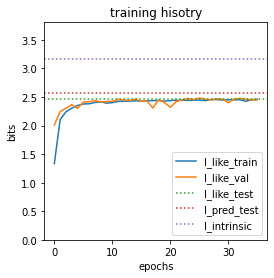

In [9]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Compute intrinsic information
I_intr, dI_intr = mavenn.I_intrinsic(y_values=y_test, dy_values=dy_test)
print(f'I_intrinsic: {I_intr:.3f} +- {dI_intr:.3f} bits')

# Compute percent info explained
pct = 100*I_pred/I_intr
dpct = 100*np.sqrt((dI_pred/I_intr)**2 + (dI_intr*I_pred/I_intr**2)**2)
print(f'percent info explained: {pct:.1f}% +- {dpct:.1f}%')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr, color='C4', linestyle=':', label='I_intrinsic')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_intr*1.2]);

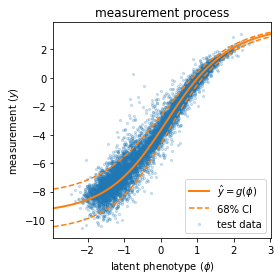

In [10]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
#ax.set_ylim([-6, 3])
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [11]:
# Plot pairwise parameters
if model.gpmap_type in ['pairwise', 'neighbor']:
    theta = model.get_theta()
    fig, ax = plt.subplots(1, 1, figsize=[8, 4])
    mavenn.heatmap_pairwise(values=theta['theta_lclc'],
                            alphabet=theta['alphabet'],
                            ax=ax);

In [12]:
# Load model
model = mavenn.load_example_model('gb1_ge_additive')

Model loaded from these files:
	/Users/jkinney/github/mavenn/mavenn/examples/models/gb1_ge_additive.pickle
	/Users/jkinney/github/mavenn/mavenn/examples/models/gb1_ge_additive.h5


On test data:
I_like_test: 2.079 +- 0.019 bits
I_pred_test: 2.193 +- 0.014 bits
I_intrinsic: 3.183 +- 0.017 bits
percent info explained: 68.9% +- 0.6%


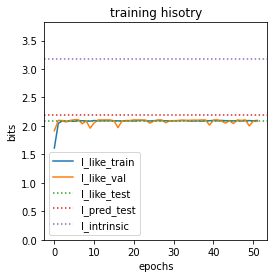

In [13]:
# Show training history
print('On test data:')

# Compute likelihood information
I_like, dI_like =  model.I_likelihood(x=x_test, y=y_test)
print(f'I_like_test: {I_like:.3f} +- {dI_like:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

# Compute intrinsic information
I_intr, dI_intr = mavenn.I_intrinsic(y_values=y_test, dy_values=dy_test)
print(f'I_intrinsic: {I_intr:.3f} +- {dI_intr:.3f} bits')

# Compute percent info explained
pct = 100*I_pred/I_intr
dpct = 100*np.sqrt((dI_pred/I_intr)**2 + (dI_intr*I_pred/I_intr**2)**2)
print(f'percent info explained: {pct:.1f}% +- {dpct:.1f}%')

I_like_hist = model.history['I_like']
val_I_like_hist = model.history['val_I_like']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_like_hist, label='I_like_train')
ax.plot(val_I_like_hist, label='I_like_val')
ax.axhline(I_like, color='C2', linestyle=':', label='I_like_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.axhline(I_intr, color='C4', linestyle=':', label='I_intrinsic')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
ax.set_ylim([0, I_intr*1.2]);